# Задача 2. Классификация даты документа

Построить модель для классификации даты (года) публикации новостной заметки из выборки lenta.ru.

В качестве векторного представления текста рассмотреть тематический вектор.

В качестве классификатора использовать любой классификатор на ваш выбор.

Проанализировать качество классификации в зависимости от добавленных модальностей.

Провести эксперимент по добавлению регуляризаторов.

Провести анализ классификации модальности(год рассмотреть как модальность) при помощи встроенных методов bigartm.

P.S. Выборку можно взять из sem-19. Времено не работает ссылка из семинара, используйте ссылку в яндексе.

In [ ]:
!pip install --quiet -U bigartm pymorphy2[fast] pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 52.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.1/371.1 kB 25.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for DAWG
ERROR: Could not build wheels for DAWG, which is required to install pyproject.toml-based projects


In [5]:
!pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 40.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=9d56d254afeb386e5789166af62f7f59d75b2c4d1d681f8e18e0d1c27aa8e1bf
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [4]:
!pip install bigartm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.1 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import gridspec

from tqdm.notebook import tqdm
import numpy as np
import  pandas as pd
import seaborn as sns
import pymorphy2
import torch
import scipy
from sklearn.utils import shuffle
import re

import artm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from torch.utils.tensorboard import SummaryWriter

# Выборка

In [5]:
data = pd.read_csv('drive/MyDrive/lenta/lenta-ru-filtered.csv')

In [6]:
data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text,tags,len,date
0,С 1 сентября на всей территории России вводитс...,Все,1654,31-08-1999
1,"По сведениям миссии ООН, передаваемым РИА ""Нов...",Все,1086,31-08-1999
2,15 представителей национал-большевистской парт...,Все,1219,31-08-1999
3,Намеченная на сегодняшний день церемония вступ...,Все,3094,31-08-1999
4,"На юге Киргизии, а именно в Баткенском и Чон-А...",Все,1354,31-08-1999
...,...,...,...,...
863280,Популярное место среди туристов в Мурманской о...,Россия,1231,11-09-2020
863281,Рейтинги от международного рейтингового агентс...,NaN,1425,11-09-2020
863282,Российские ученые нашли в Якутии новый подвид ...,События,1299,11-09-2020
863283,Для указания коронавируса как причины смерти ч...,Общество,2061,11-09-2020


сразу отметим, что целевой переменной является дата, а в качестве модальностей кроме text можем еще использовать tags и len

## Предобработка текстов

предобработанный текст тоже возьмем уже готовый, но все равно оставим код который нужен для обработки

## Токенизаторы

In [ ]:
import nltk
from nltk.tokenize import RegexpTokenizer
nltk.download('punkt')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
word_tokenizer = RegexpTokenizer(r'[a-zа-яёЁА-ЯA-Z]+|[^\w\s]|\d+')
sent_tokenizer = lambda sent: nltk.sent_tokenize(sent, language="russian")

## Лематизатор для русского

In [ ]:
nltk.download('stopwords')
# pymorphy2 анализатор
morph = pymorphy2.MorphAnalyzer()
# стоп слова из nltk
stops = nltk.corpus.stopwords.words('russian')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.10/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)


In [ ]:
def proccess_text(text):
    text= text.lower()
    sents = sent_tokenizer(text)
    words = list(
        itertools.chain.from_iterable(
            word_tokenizer.tokenize_sents(sents)))
    return [x for x in [morph.normal_forms(word)[0] for word in words ]\
            if x not in stops]

In [5]:
# data_text = data['text']
# for i in tqdm(range(len(data))):
#     data_text.loc[i] = ' '.join(proccess_text(data_text.loc[i]))
# data.to_csv('lenta-ru-proccess.csv', index=False)

data = pd.read_csv('drive/MyDrive/lenta/lenta-ru-proccess.csv')

In [8]:
data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text,tags,len,date
0,1 сентябрь весь территория россия вводиться но...,Все,1654,31-08-1999
1,"сведение миссия оон , передаваемый риа "" новос...",Все,1086,31-08-1999
2,15 представитель национал - большевистский пар...,Все,1219,31-08-1999
3,наметить сегодняшний день церемония вступление...,Все,3094,31-08-1999
4,"юг киргизия , именно баткенский чон - алайском...",Все,1354,31-08-1999
...,...,...,...,...
863280,популярный место среди турист мурманский облас...,Россия,1231,11-09-2020
863281,рейтинг международный рейтинговый агентство s ...,NaN,1425,11-09-2020
863282,российский учёный найти якутия новый подвид ар...,События,1299,11-09-2020
863283,указание коронавирус причина смерть человек не...,Общество,2061,11-09-2020


# BigARTM

## Перевод данных в формат данных для bigartm (+ деление на train/valid)

In [6]:
filename_valid = ('drive/MyDrive/lenta/texts_valid.vw.txt')
filename_train = ('drive/MyDrive/lenta/texts_train.vw.txt')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
counter_train = 0
counter_valid = 0

y_train = []
y_valid = []

reg = re.compile(r'\W+')
with open(filename_valid, 'w') as fout_valid:
    with open(filename_train, 'w') as fout_train:
        for i in tqdm(range(len(data))):
            if (data.loc[i]['tags'] is np.nan):
              continue
            text = (reg.sub(' ', data.loc[i]['text']).strip()).split()
            #print(data.loc[i]['tags'])
            label = str(data.loc[i]['tags']).lower().strip()


            if len(text) > 100:
                if (i + 1) % 100 == 0:
                    fout_valid.write('doc_{} {} |@tags class_{}\n'.format(
                        counter_train, ' '.join(text), label))
                    counter_train += 1
                    y_valid.append((data.loc[i]['date'].split('-')[-1]))
                else:
                    fout_train.write('doc_{} {} |@tags class_{}\n'.format(
                        counter_valid, ' '.join(text), label))
                    counter_valid += 1
                    y_train.append((data.loc[i]['date'].split('-')[-1]))

  0%|          | 0/863285 [00:00<?, ?it/s]

In [ ]:
with open('drive/MyDrive/lenta/y_valid.vw.txt', 'w') as f:
    f.write('\n'.join(y_valid))

with open('drive/MyDrive/lenta/y_train.vw.txt', 'w') as f:
    f.write('\n'.join(y_train))

In [7]:
with open('drive/MyDrive/lenta/y_valid.vw.txt') as f:
    y_valid = f.read().split('\n')

with open('drive/MyDrive/lenta/y_train.vw.txt') as f:
    y_train = f.read().split('\n')

## Смотрим на данные

In [ ]:
!head -2 drive/MyDrive/lenta/texts_valid.vw.txt

doc_0 причина смерть меньший мера 34 малазийский ребёнок возраст 5 месяц 7 год стать неизвестный вирус вызывающий прекращение деятельность сердце мозг утверждать учёный проводить свой исследование страна это сегодня утром сообщить радиостанция ввс первоначально предполагаться причина смерть стать давно известный врач сезонный лихорадка однако поздний выясниться сердце мозг ребёнок поразить неизвестный вирус наблюдение пациент госпиталь субить опубликовать исследователь журнал the lancet доказать большинство умерший ребёнок развиться миокардит воспаление мозг вызвать сезонный лихорадка возбудитель болезнь признанный аденовирус назвать учёный agent y правило аденовирус опасный жизнь вызывать нетяжелый заболевание тип известный простуда однако именно agent y обнаружить исследование ткань сердце мозг погибший ребёнок учёный вынудить признать видимо речь идти новый разновидность вирус возникнуть южный азия утверждение bbc вспышка похожий заболевание произойти 1998 год тайвань |@tags class_в

In [ ]:
!head -2 drive/MyDrive/lenta/texts_train.vw.txt

doc_0 1 сентябрь весь территория россия вводиться новый форма таможенный декларация физический лицо пояснить государственный таможенный комитет гтк форма декларация который одобрить совет руководитель таможенный служба государство участник содружество являться единый территория весь страна снг исключение армения данные итар тасс новый декларация содержаться подробный перечень товар подлежащее обязательный декларирование впервые число включить ядовитый сильно действующий вещество лекарство радиоактивный материал объект флор фауна также высокочастотный радио электронный устройство средство связь частность система радиолокация кабельный телевидение средство мобильный связь частота выше 9 килогерц кроме декларация необходимый приводить подробный сведение ввозить вывозить транспортный средство вид машинs год выпуск объесть двигатель номер двигатель кузов шасси россия новый форма декларация наряду прежний применяться 1 август лишь московский таможенный пункт шереметьево внуково домодедово чк

In [ ]:
print(len(set(y_valid)))

22


# Создаем батчи

In [8]:
bv_train = artm.BatchVectorizer(
    data_path=filename_train, data_format='vowpal_wabbit', batch_size=10000,
    target_folder='drive/MyDrive/lenta/batches_train')

bv_test = artm.BatchVectorizer(
    data_path=filename_valid, data_format='vowpal_wabbit', batch_size=10000,
    target_folder='drive/MyDrive/lenta/batches_valid')

# Создаем словарь

In [9]:
dictionary = artm.Dictionary()
dictionary.gather(data_path='drive/MyDrive/lenta/batches_train')

# Создаем модель

Загрузка из дампа

In [10]:

model = artm.load_artm_model('./drive/MyDrive/lenta/without_regular/')

model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary), overwrite=True)

## Обучаем новую

In [ ]:
model = artm.ARTM(num_topics=200,
                  dictionary=dictionary,
                  class_ids={'@default_class': 1.0,
                             '@tags': 10.0})

model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))
model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))
model.scores.add(artm.SparsityPhiScore(name='sparsity', class_id='@tags'))

In [ ]:
iterator = tqdm(range(10))
for i in iterator:
    model.fit_offline(bv_train, num_collection_passes=1)
    iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1],
                          'sparsity': model.score_tracker['sparsity'].value[-1],})

In [ ]:
model.dump_artm_model('drive/MyDrive/lenta/without_regular')

# Анализ метрик

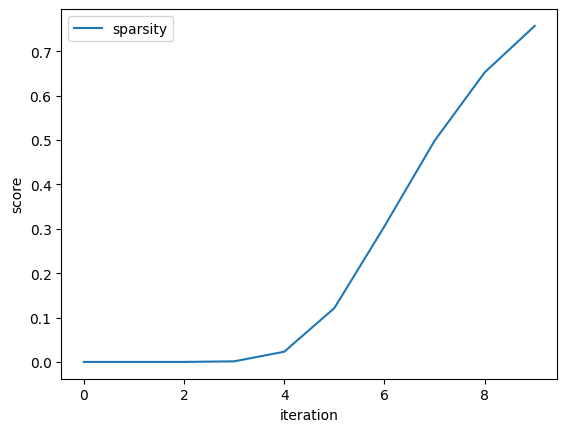

In [ ]:
plt.plot(model.score_tracker['sparsity'].value, label = 'sparsity')

plt.legend(loc = 'best')

plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

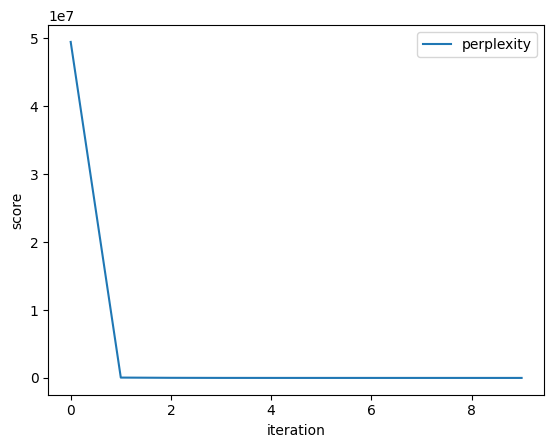

In [ ]:
plt.plot(model.score_tracker['perplexity'].value, label = 'perplexity')

plt.legend(loc = 'best')

plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

## Собственно классификация

In [9]:
X_train_pd = model.transform(bv_train)

In [18]:
len(X_train_pd)

200

In [19]:
len(y_train)

631985

In [20]:
X_train_pd[0]

topic_0      5.181323e-02
topic_1      9.820318e-05
topic_2      5.487342e-07
topic_3      5.139030e-04
topic_4      2.462310e-02
                 ...     
topic_195    3.323189e-07
topic_196    5.353784e-09
topic_197    1.987143e-05
topic_198    6.244724e-06
topic_199    4.306275e-05
Name: 0, Length: 200, dtype: float32

In [10]:
with open('drive/MyDrive/lenta/y_valid.vw.txt') as f:
    y_valid = f.read().split('\n')

with open('drive/MyDrive/lenta/y_train.vw.txt') as f:
    y_train = f.read().split('\n')

In [ ]:
X_train_pd.iloc[:,0].values

In [11]:
X_train = []
for i in tqdm(range(len(y_train))):
    X_train.append(X_train_pd[i].values)

  0%|          | 0/631985 [00:00<?, ?it/s]

In [12]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [24]:
len(X_train)

631985

In [13]:
X_train, y_train = shuffle(X_train, y_train)

In [14]:
X_train = X_train[:20000]
y_train = y_train[:20000]

In [15]:
classifier = RandomForestClassifier(n_estimators=14)

In [16]:
classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=14)

In [17]:
X_valid_pd = model.transform(bv_test)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
X_valid = []
for i in tqdm(range(len(y_valid))):
    X_valid.append(X_valid_pd[i].values)

  0%|          | 0/6396 [00:00<?, ?it/s]

In [19]:
pred = classifier.predict(X_valid)

In [20]:
print(classification_report(y_valid, pred, zero_division=1))

              precision    recall  f1-score   support

        1999       0.00      0.00      0.00        19
        2000       0.05      0.04      0.05        69
        2001       0.01      0.01      0.01        96
        2002       0.11      0.08      0.09       143
        2003       0.07      0.07      0.07       134
        2004       0.08      0.07      0.07       183
        2005       0.09      0.12      0.10       240
        2006       0.08      0.09      0.08       256
        2007       0.07      0.08      0.07       235
        2008       0.09      0.14      0.11       332
        2009       0.15      0.19      0.17       423
        2010       0.09      0.10      0.10       375
        2011       0.13      0.13      0.13       384
        2012       0.12      0.12      0.12       427
        2013       0.12      0.09      0.10       323
        2014       0.17      0.13      0.15       276
        2015       0.13      0.13      0.13       351
        2016       0.14    

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ну, лучше рандома, но качество не очень 😢


In [51]:
classifier = RandomForestClassifier(n_estimators=11, max_depth=6)
classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, n_estimators=11)

In [52]:
pred = classifier.predict(X_valid)

In [53]:
print(classification_report(y_valid, pred, zero_division=1))

              precision    recall  f1-score   support

        1999       1.00      0.00      0.00        19
        2000       1.00      0.00      0.00        69
        2001       1.00      0.00      0.00        96
        2002       0.00      0.00      0.00       143
        2003       0.33      0.01      0.01       134
        2004       0.22      0.01      0.02       183
        2005       0.18      0.06      0.09       240
        2006       0.07      0.01      0.02       256
        2007       0.00      0.00      0.00       235
        2008       0.10      0.06      0.08       332
        2009       0.17      0.22      0.19       423
        2010       0.10      0.04      0.06       375
        2011       0.15      0.14      0.15       384
        2012       0.12      0.43      0.19       427
        2013       0.17      0.03      0.05       323
        2014       0.27      0.05      0.08       276
        2015       0.12      0.03      0.05       351
        2016       0.14    

не получилось нормально увеличить 🤔, попробуем добавить регуляризаторов в модель 🥰

# Добавим регуляризаторов

In [13]:

model_regul = artm.load_artm_model('./drive/MyDrive/lenta/with_regul/')

model_regul.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary), overwrite=True)

In [54]:
model_regul = artm.ARTM(num_topics=200,
                  dictionary=dictionary,
                  class_ids={'@default_class': 1.0,
                             '@tags': 10.0})

model_regul.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))
model_regul.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))
model_regul.scores.add(artm.SparsityPhiScore(name='sparsity', class_id='@tags'))

чтобы модель смогла нормально обучаться нужно поочереди включать регуляризоторы (включить один, сделать несколько итераций, выключить или оставить, включить другой)

In [55]:
model_regul.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decor',
                                                       tau=10000,
                                                       class_ids=['@default_class', '@tags']))

In [56]:
iterator = tqdm(range(5))
for i in iterator:
    model_regul.fit_offline(bv_train, num_collection_passes=1)
    iterator.set_postfix({'perplexity': model_regul.score_tracker['perplexity'].value[-1],
                          'sparsity': model_regul.score_tracker['sparsity'].value[-1],})

  0%|          | 0/5 [00:00<?, ?it/s]

In [57]:
model_regul.regularizers.add(artm.SmoothSparsePhiRegularizer(name='smooth',
                                                       tau=10,
                                                       class_ids=['@default_class', '@tags']))

In [58]:
iterator = tqdm(range(5))
for i in iterator:
    model_regul.fit_offline(bv_train, num_collection_passes=1)
    iterator.set_postfix({'perplexity': model_regul.score_tracker['perplexity'].value[-1],
                          'sparsity': model_regul.score_tracker['sparsity'].value[-1],})

  0%|          | 0/5 [00:00<?, ?it/s]

In [59]:
model_regul.dump_artm_model('drive/MyDrive/lenta/with_regul')

классификация

In [14]:
X_train_pd = model_regul.transform(bv_train)

In [15]:
with open('drive/MyDrive/lenta/y_valid.vw.txt') as f:
    y_valid = f.read().split('\n')

with open('drive/MyDrive/lenta/y_train.vw.txt') as f:
    y_train = f.read().split('\n')

In [16]:
X_train = []
for i in tqdm(range(len(y_train))):
    X_train.append(X_train_pd[i].values)

  0%|          | 0/631985 [00:00<?, ?it/s]

In [17]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_train, y_train = shuffle(X_train, y_train)
X_train = X_train[:20000]
y_train = y_train[:20000]

In [18]:
classifier = RandomForestClassifier(n_estimators=11, max_depth=6)
classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, n_estimators=11)

In [19]:
X_valid_pd = model_regul.transform(bv_test)

In [20]:
X_valid = []
for i in tqdm(range(len(y_valid))):
    X_valid.append(X_valid_pd[i].values)

  0%|          | 0/6396 [00:00<?, ?it/s]

In [21]:
pred = classifier.predict(X_valid)

In [22]:
print(classification_report(y_valid, pred, zero_division=1))

              precision    recall  f1-score   support

        1999       1.00      0.00      0.00        19
        2000       1.00      0.00      0.00        69
        2001       0.00      0.00      0.00        96
        2002       1.00      0.00      0.00       143
        2003       1.00      0.00      0.00       134
        2004       1.00      0.00      0.00       183
        2005       0.50      0.03      0.05       240
        2006       1.00      0.00      0.00       256
        2007       1.00      0.00      0.00       235
        2008       0.08      0.00      0.01       332
        2009       0.16      0.23      0.19       423
        2010       0.18      0.03      0.05       375
        2011       0.16      0.01      0.01       384
        2012       0.12      0.73      0.20       427
        2013       0.33      0.04      0.08       323
        2014       0.35      0.03      0.05       276
        2015       0.19      0.02      0.04       351
        2016       0.16    

accuracy немного уменьшилась, но зато макрохарактеристики увеличились

# Изменим модальности

можем убрать модальность тэга и добавить модальность длины и посмотреть что получится, по идее качество должно упасть, так как дополнительной информации в виде тэга не будет, а длина малоинформативна

In [7]:
filename_valid_notag = ('drive/MyDrive/lenta/texts_valid_notag.vw.txt')
filename_train_notag = ('drive/MyDrive/lenta/texts_train_notag.vw.txt')

In [ ]:
counter_train = 0
counter_valid = 0

y_train_notag = []
y_valid_notag = []

reg = re.compile(r'\W+')
with open(filename_valid_notag, 'w') as fout_valid:
    with open(filename_train_notag, 'w') as fout_train:
        for i in tqdm(range(len(data))):
            text = (reg.sub(' ', data.loc[i]['text']).strip()).split()
            #print(data.loc[i]['tags'])
            label = str(data.loc[i]['len'])


            if len(text) > 100:
                if (i + 1) % 100 == 0:
                    fout_valid.write('doc_{} {} |@len class_{}\n'.format(
                        counter_train, ' '.join(text), label))
                    counter_train += 1
                    y_valid_notag.append((data.loc[i]['date'].split('-')[-1]))
                else:
                    fout_train.write('doc_{} {} |@len class_{}\n'.format(
                        counter_valid, ' '.join(text), label))
                    counter_valid += 1
                    y_train_notag.append((data.loc[i]['date'].split('-')[-1]))

  0%|          | 0/863285 [00:00<?, ?it/s]

In [ ]:
with open('drive/MyDrive/lenta/y_valid_notag.vw.txt', 'w') as f:
    f.write('\n'.join(y_valid_notag))

with open('drive/MyDrive/lenta/y_train_notag.vw.txt', 'w') as f:
    f.write('\n'.join(y_train_notag))

In [16]:
with open('drive/MyDrive/lenta/y_valid_notag.vw.txt') as f:
    y_valid_notag = f.read().split('\n')

with open('drive/MyDrive/lenta/y_train_notag.vw.txt') as f:
    y_train_notag = f.read().split('\n')

In [8]:
bv_train_notag = artm.BatchVectorizer(
    data_path=filename_train_notag, data_format='vowpal_wabbit', batch_size=10000,
    target_folder='drive/MyDrive/lenta/batches_train_notag')

bv_test_notag = artm.BatchVectorizer(
    data_path=filename_valid_notag, data_format='vowpal_wabbit', batch_size=10000,
    target_folder='drive/MyDrive/lenta/batches_valid_notag')

In [9]:
dictionary_notag = artm.Dictionary()
dictionary_notag.gather(data_path='drive/MyDrive/lenta/batches_train_notag')

In [11]:
model_notag = artm.load_artm_model('./drive/MyDrive/lenta/without_regular_notag/')

model_notag.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary_notag), overwrite=True)

FileNotFoundError: [Errno 2] No such file or directory: './drive/MyDrive/lenta/without_regular_notag/parameters.bin'

In [12]:
model_notag = artm.ARTM(num_topics=200,
                  dictionary=dictionary_notag,
                  class_ids={'@default_class': 1.0,
                             '@len': 5.0})

model_notag.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary_notag))
model_notag.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))
model_notag.scores.add(artm.SparsityPhiScore(name='sparsity', class_id='@len'))

In [13]:
iterator = tqdm(range(10))
for i in iterator:
    model_notag.fit_offline(bv_train_notag, num_collection_passes=1)
    iterator.set_postfix({'perplexity': model_notag.score_tracker['perplexity'].value[-1],
                          'sparsity': model_notag.score_tracker['sparsity'].value[-1],})

  0%|          | 0/10 [00:00<?, ?it/s]

In [14]:
model_notag.dump_artm_model('drive/MyDrive/lenta/without_regular_notag')

In [17]:
X_train_pd_notag = model_notag.transform(bv_train_notag)
X_train_notag = []
for i in tqdm(range(len(y_train_notag))):
    X_train_notag.append(X_train_pd_notag[i].values)

X_train_notag = np.array(X_train_notag)
y_train_notag = np.array(y_train_notag)

  0%|          | 0/653795 [00:00<?, ?it/s]

In [18]:
X_train_notag, y_train_notag = shuffle(X_train_notag, y_train_notag)
X_train_notag = X_train_notag[:20000]
y_train_notag = y_train_notag[:20000]

In [19]:
classifier_notag = RandomForestClassifier(n_estimators=11, max_depth=6)
classifier_notag.fit(X_train_notag, y_train_notag)

RandomForestClassifier(max_depth=6, n_estimators=11)

In [20]:
X_valid_pd_notag = model_notag.transform(bv_test_notag)
X_valid_notag = []
for i in tqdm(range(len(y_valid_notag))):
    X_valid_notag.append(X_valid_pd_notag[i].values)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/6604 [00:00<?, ?it/s]

In [22]:
pred_notag = classifier_notag.predict(X_valid_notag)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
print(classification_report(y_valid_notag, pred_notag, zero_division=1))

              precision    recall  f1-score   support

        1999       1.00      0.00      0.00        19
        2000       1.00      0.00      0.00        69
        2001       0.00      0.00      0.00        96
        2002       0.00      0.00      0.00       143
        2003       0.00      0.00      0.00       134
        2004       0.18      0.01      0.02       183
        2005       0.00      0.00      0.00       240
        2006       0.08      0.00      0.01       256
        2007       0.00      0.00      0.00       236
        2008       0.11      0.04      0.06       332
        2009       0.11      0.17      0.13       423
        2010       0.12      0.12      0.12       375
        2011       0.10      0.19      0.13       384
        2012       0.09      0.02      0.04       427
        2013       0.15      0.09      0.11       387
        2014       0.24      0.04      0.07       309
        2015       0.18      0.05      0.07       387
        2016       0.11    

Итого мы получили, что качество ухудшилось. Это быо ожидаемо, так как мы убрали довольно информативную модальность - теги, вместо нее была добавлена модальность длины, которая вряд ли несет какой-то смысл.